In [1]:
# General Imports
import numpy as np
from math import pi

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pandas Imports
import pandas as pd

#Seaborn Imports
import seaborn as sns

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

In [2]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [3]:
def support_vector_machine(hd, list_feature, kernel, random_state = 0):
    sample_train, sample_test, label_train, label_test = train_test_split(hd[list_feature],
                                                                          hd['condition'],test_size=0.3,
                                                                          random_state=random_state,
                                                                          stratify=hd['condition'])
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Select
    train_size = len(sample_train)

    label_train = label_train[:train_size].to_numpy(copy="True")

    test_size = len(sample_test)
    sample_test = sample_test[:test_size]
    label_test = label_test[:test_size].to_numpy(copy="True")

    output_svc = SVC(kernel=kernel)
    output_svc.fit(sample_train, label_train)

    return output_svc, sample_test, label_test

In [4]:
def show_metrics(data, list_feature, kernel, random_state):
    print("random state", random_state)
    print(list_feature)
    print()
    svc_output , sample_test, y_true = support_vector_machine(data, list_feature, kernel,
                                                                 random_state = random_state)
    y_pred = svc_output.predict(sample_test)
    print(classification_report(y_true, y_pred))
    y_score = svc_output.decision_function(sample_test)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label =\
     r"ROC (AUC = %0.3f )" % roc_auc_score(y_true, y_score) )

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
heart_data = pd.read_csv("heart_disease_df.csv")

In [6]:
def get_condition(row):
    if row['diagnosis'] == 0 :
        return 0.0
    return 1.0

heart_data = heart_data.drop(columns = ['Unnamed: 0', 'ca', 'thal', 'Source'])
mean_trestbps = heart_data.query("trestbps != 0.0")['trestbps'].mean()
heart_data.loc[heart_data["trestbps"] == 0.0, "trestbps"] = mean_trestbps
heart_data['trestbps'] = heart_data['trestbps'].fillna(mean_trestbps)

mean_chol = heart_data.query("chol != 0.0")['chol'].mean()
heart_data.loc[heart_data["chol"] == 0.0, "chol"] = mean_chol
heart_data['chol'] = heart_data['chol'].fillna(mean_chol)

mean_fbs = heart_data['fbs'].mean()
heart_data['fbs'] = heart_data['fbs'].fillna(mean_fbs)

heart_data['oldpeak'] = abs(heart_data['oldpeak']) 
mean_oldpeak = heart_data['oldpeak'].mean()
heart_data['oldpeak'] = heart_data['oldpeak'].fillna(mean_oldpeak)

heart_data.loc[heart_data["restecg"] == 2.0, "restecg"] = 3.0
heart_data.loc[heart_data["restecg"] == 1.0, "restecg"] = 2.0
heart_data.loc[heart_data["restecg"] == 3.0, "restecg"] = 1.0
mean_restecg = heart_data['restecg'].mean()
heart_data['restecg'] = heart_data['restecg'].fillna(mean_restecg)

heart_data['slope'] = heart_data['slope'].fillna(2.0) 
heart_data.loc[heart_data["oldpeak"] < 1.0, "slope"] = 1.0
heart_data.loc[heart_data["slope"] == 2.0, "slope"] = 4.0
heart_data.loc[heart_data["slope"] == 3.0, "slope"] = 2.0
heart_data.loc[heart_data["slope"] == 4.0, "slope"] = 3.0

mean_thalach = heart_data['thalach'].mean()
heart_data['thalach'] = heart_data['thalach'].fillna(mean_thalach)

mean_exang = heart_data['exang'].mean()
heart_data['exang'] = heart_data['exang'].fillna(mean_exang)

heart_data['condition'] = heart_data.apply(lambda row: get_condition(row) , axis = 1)
heart_data = heart_data.drop(columns = ['diagnosis'])
heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,condition
count,920.000,920.000,920.000,920.000,920.000,920.000,920.000,920.000,920.000,920.000,920.000,920.000
mean,53.511,0.789,3.250,132.286,246.833,0.166,0.595,137.546,0.390,0.908,1.634,0.553
std,9.425,0.408,0.931,17.921,51.696,0.354,0.794,25.138,0.473,1.030,0.897,0.497
min,28.000,0.000,1.000,80.000,85.000,0.000,0.000,60.000,0.000,0.000,1.000,0.000
25%,47.000,1.000,3.000,120.000,217.750,0.000,0.000,120.000,0.000,0.000,1.000,0.000
50%,54.000,1.000,4.000,130.000,246.833,0.000,0.000,138.000,0.000,0.800,1.000,1.000
75%,60.000,1.000,4.000,140.000,267.000,0.000,1.000,156.000,1.000,1.500,3.000,1.000
max,77.000,1.000,4.000,200.000,603.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


In [7]:
heart_data.shape

(920, 12)

In [8]:
heart_data.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,condition
age,1.000,0.057,0.166,0.244,0.074,0.223,0.210,-0.353,0.195,0.250,0.143,0.283
sex,0.057,1.000,0.170,0.005,-0.088,0.086,0.042,-0.177,0.179,0.120,0.065,0.307
cp,0.166,0.170,1.000,0.023,0.087,0.038,0.064,-0.339,0.407,0.249,0.265,0.472
trestbps,0.244,0.005,0.023,1.000,0.073,0.136,0.108,-0.102,0.150,0.143,0.109,0.113
chol,0.074,-0.088,0.087,0.073,1.000,0.051,0.005,-0.039,0.073,0.042,0.098,0.105
fbs,0.223,0.086,0.038,0.136,0.051,1.000,0.163,-0.048,0.025,0.048,0.027,0.136
restecg,0.210,0.042,0.064,0.108,0.005,0.163,1.000,-0.079,0.079,0.105,-0.001,0.111
thalach,-0.353,-0.177,-0.339,-0.102,-0.039,-0.048,-0.079,1.000,-0.356,-0.170,-0.255,-0.383
exang,0.195,0.179,0.407,0.150,0.073,0.025,0.079,-0.356,1.000,0.391,0.428,0.450
oldpeak,0.250,0.120,0.249,0.143,0.042,0.048,0.105,-0.170,0.391,1.000,0.673,0.399


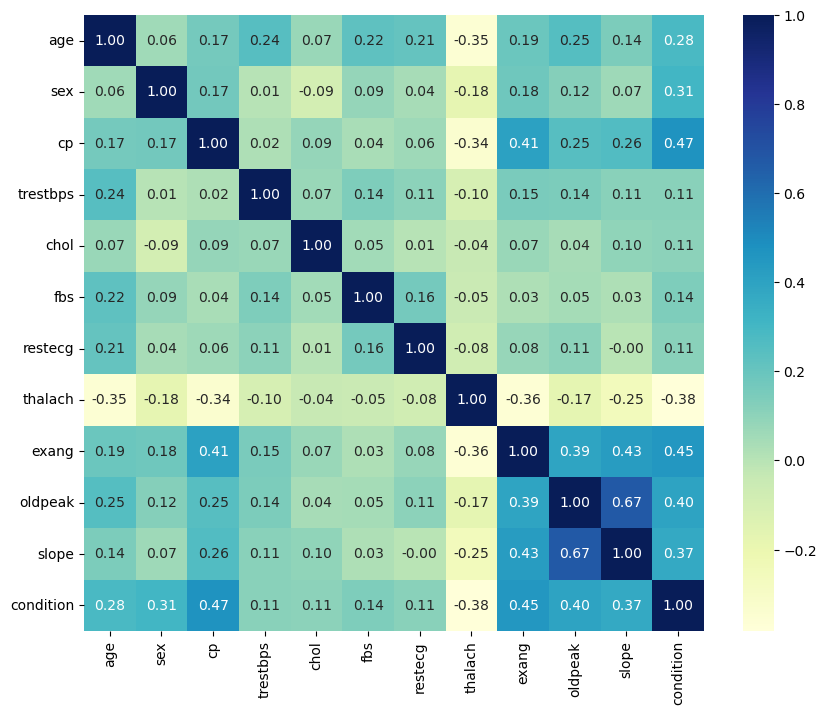

In [9]:
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(heart_data.corr(),
                annot = True,
                fmt = ".2f",
                cmap = 'YlGnBu')

## TwoLocal 4-qubit feature map for 11 features

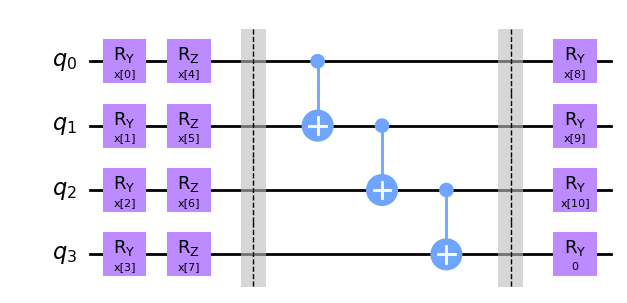

In [10]:
p1 = ParameterVector('x', 11)  
feature_map = QuantumCircuit(4)
for i in range(4):
    feature_map.ry(p1[i],i)
for i in range(4):
    feature_map.rz(p1[i+4],i)
feature_map.barrier()
for i in range(3):
    feature_map.cx(i,i+1)
feature_map.barrier()
for i in range(3):
    feature_map.ry(p1[i+8],i)
feature_map.ry(0,3)
feature_map.draw(output="mpl")

In [11]:
zz_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [12]:
list_feature =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                   'thalach',  'exang', 'oldpeak', 'slope']               
nb_row = 100
np_score = np.zeros([nb_row, 2], dtype=float)
for i, random_state in enumerate(range(nb_row)):
        output_svc, sample_test, label_test = support_vector_machine(heart_data,
                                                                      list_feature,
                                                                      "linear",
                                                                      random_state)
        np_score[i][0] = output_svc.score(sample_test, label_test)
        

### Finding random state corresponding to mean accuracy value

In [21]:
list_feature =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                   'thalach',  'exang', 'oldpeak', 'slope']               
nb_row = 100
np_score = np.zeros([nb_row, 2], dtype=float)

In [22]:
def compute_accuracy(df, list_feature, kernel, random_state):
        output_svc, sample_test, label_test = support_vector_machine(df,
                                                                     list_feature,
                                                                     kernel,
                                                                     random_state)
        return accuracy_score(label_test, output_svc.predict(sample_test))  

In [23]:
for i, random_state in enumerate(range(nb_row)):            
    np_score[i][0] = compute_accuracy(heart_data,
                                      list_feature,
                                      "linear",
                                      random_state)
    np_score[i][1] = compute_accuracy(heart_data,
                                      list_feature,
                                      zz_kernel.evaluate,
                                      random_state) 
    print(np_score[i])

[0.77898551 0.76811594]
[0.80072464 0.8115942 ]
[0.77173913 0.76811594]
[0.77898551 0.77898551]
[0.80434783 0.81521739]
[0.8115942  0.81521739]
[0.79347826 0.80072464]
[0.78985507 0.7826087 ]
[0.78985507 0.80072464]
[0.83695652 0.79710145]
[0.78623188 0.78985507]
[0.84057971 0.84057971]
[0.7826087 0.75     ]
[0.75362319 0.75      ]
[0.79710145 0.7826087 ]
[0.80072464 0.78985507]
[0.84782609 0.81521739]
[0.80434783 0.80072464]
[0.80072464 0.78985507]
[0.81884058 0.80434783]
[0.78985507 0.7826087 ]
[0.82608696 0.79347826]
[0.82971014 0.8115942 ]
[0.8115942  0.79347826]
[0.79347826 0.75724638]
[0.80072464 0.77898551]
[0.8115942  0.80434783]
[0.79347826 0.79710145]
[0.82971014 0.8115942 ]
[0.77536232 0.76811594]
[0.79710145 0.82608696]
[0.78623188 0.78985507]
[0.77173913 0.78623188]
[0.76449275 0.75724638]
[0.79347826 0.77173913]
[0.7826087  0.78985507]
[0.84057971 0.82246377]
[0.81884058 0.78623188]
[0.78985507 0.77898551]
[0.80072464 0.83695652]
[0.81884058 0.79710145]
[0.78623188 0.8079

In [28]:
columns_values = ['classical','qsvm']
index_values = list(range(nb_row))
acc_df = pd.DataFrame(data = np_score, index = index_values,
                  columns = columns_values)
acc_df.describe()    

,classical,qsvm
count,100.000,100.000
mean,0.801,0.795
std,0.021,0.021
min,0.750,0.750
25%,0.790,0.783
50%,0.801,0.793
75%,0.812,0.808
max,0.848,0.851


In [32]:
# was run
#acc_df.to_csv('acc.csv', index=False)

In [29]:
from scipy.stats import ttest_rel
ttest_rel(acc_df.classical, acc_df.qsvm)

Ttest_relResult(statistic=3.454156963989482, pvalue=0.0008140014800410685)

In [30]:
from scipy.stats import linregress
res = linregress(acc_df.classical, acc_df.qsvm)
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.412492


In [36]:
print(res)

LinregressResult(slope=0.6402892555614811, intercept=0.28209582785475407, rvalue=0.6422551455389923, pvalue=5.932190764735438e-13, stderr=0.0771902766652936, intercept_stderr=0.0618538428673046)


In [61]:
dist_array = ( np_score[:,0]-np.mean(np_score[:,0]) )**2\
             + ( np_score[:,1]-np.mean(np_score[:,1]) )**2
random_state = dist_array.argmin()
print("random_state for score nearest to the mean intersection:", random_state)
print("classical score :", np_score[:,0][random_state])
print("     qsvm score :", np_score[:,1][random_state])                

random_state for score nearest to the mean intersection: 72
classical score : 0.8007246376811594
     qsvm score : 0.7934782608695652


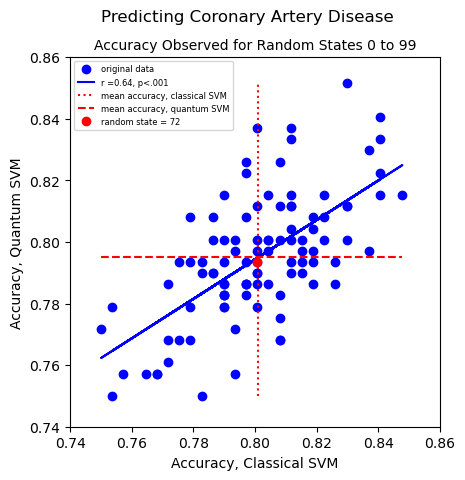

In [143]:
x = acc_df.classical
y = acc_df.qsvm
plt.plot(x, y, 'ob', label='original data')
plt.suptitle("Predicting Coronary Artery Disease" )
plt.title("Accuracy Observed for Random States 0 to 99", fontsize = 10) 
plt.xlabel("Accuracy, Classical SVM")
plt.ylabel("Accuracy, Quantum SVM")
plt.plot(x, res.intercept + res.slope*x, 'b',
         label='r ='+str(res.rvalue)[:4]+", p<.001"  )
plt.vlines( np.mean(x), np.min(y), np.max(y), 'r',
           linestyles='dotted', label = 'mean accuracy, classical SVM')
plt.hlines( np.mean(y), np.min(x), np.max(x), 'r',
           linestyles='dashed', label = 'mean accuracy, quantum SVM')
plt.plot(np_score[:,0][random_state], np_score[:,1][random_state],
         'or', label = #"nearest # to means\
          "random state = " + str(random_state) )
plt.legend(loc=2, prop={'size': 6})
plt.xlim(0.74, 0.86)
plt.ylim(0.74, 0.86)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

random state 72
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       123
         1.0       0.83      0.81      0.82       153

    accuracy                           0.80       276
   macro avg       0.80      0.80      0.80       276
weighted avg       0.80      0.80      0.80       276



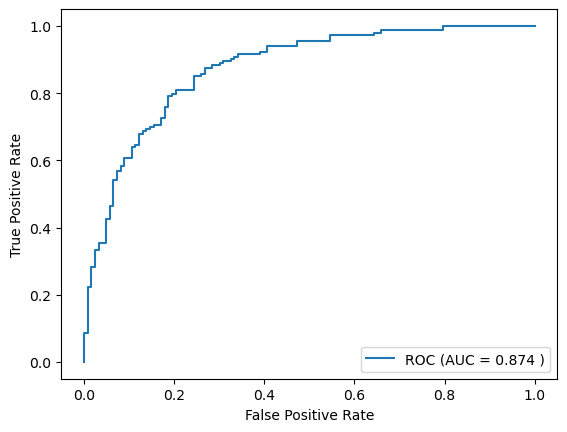

In [95]:
show_metrics(heart_data, list_feature, "linear", random_state)

random state 72
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       123
         1.0       0.80      0.84      0.82       153

    accuracy                           0.79       276
   macro avg       0.79      0.79      0.79       276
weighted avg       0.79      0.79      0.79       276



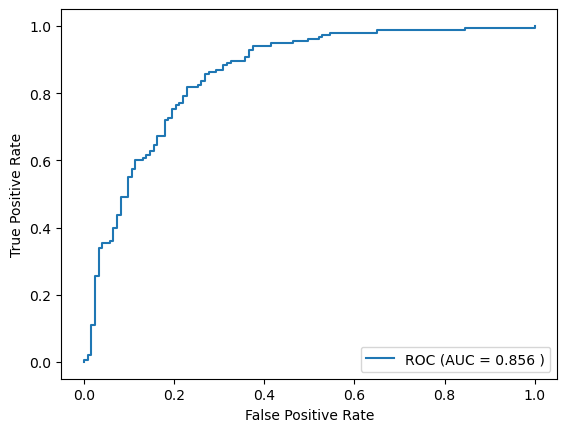

In [96]:
show_metrics(heart_data, list_feature, zz_kernel.evaluate, random_state)

### Other random states

random_state for score nearest to the classical mean: 1
score for this random_state: 0.8007246376811594
random state 1
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78       123
         1.0       0.82      0.82      0.82       153

    accuracy                           0.80       276
   macro avg       0.80      0.80      0.80       276
weighted avg       0.80      0.80      0.80       276



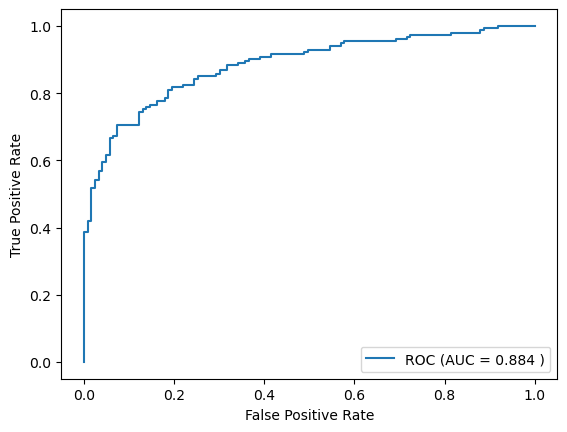

In [108]:
difference_array = np.absolute(np_score[:,0]-np.mean(np_score[:,0]))
random_state = difference_array.argmin()
print("random_state for score nearest to the classical mean:", random_state)
print("score for this random_state:", np_score[:,0][random_state])
show_metrics(heart_data, list_feature, "linear", random_state)

random state 1
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       123
         1.0       0.81      0.86      0.84       153

    accuracy                           0.81       276
   macro avg       0.81      0.81      0.81       276
weighted avg       0.81      0.81      0.81       276



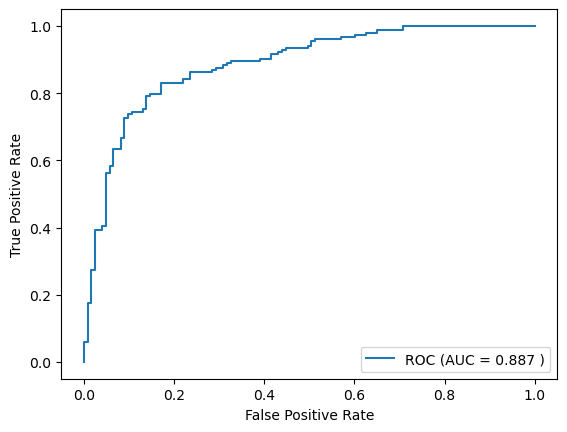

In [109]:
show_metrics(heart_data, list_feature, zz_kernel.evaluate, random_state)

random_state for score nearest to the quantum mean: 21
score for this random_state: 0.7934782608695652
random state 21
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       123
         1.0       0.80      0.84      0.82       153

    accuracy                           0.79       276
   macro avg       0.79      0.79      0.79       276
weighted avg       0.79      0.79      0.79       276



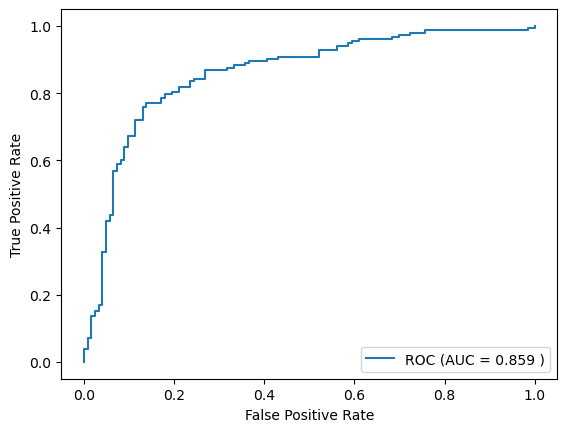

In [110]:
difference_array = np.absolute(np_score[:,1]-np.mean(np_score[:,1]))
random_state = difference_array.argmin()
print("random_state for score nearest to the quantum mean:", random_state)
print("score for this random_state:", np_score[:,1][random_state])
show_metrics(heart_data, list_feature, zz_kernel.evaluate, random_state)

random state 21
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       123
         1.0       0.84      0.85      0.84       153

    accuracy                           0.83       276
   macro avg       0.82      0.82      0.82       276
weighted avg       0.83      0.83      0.83       276



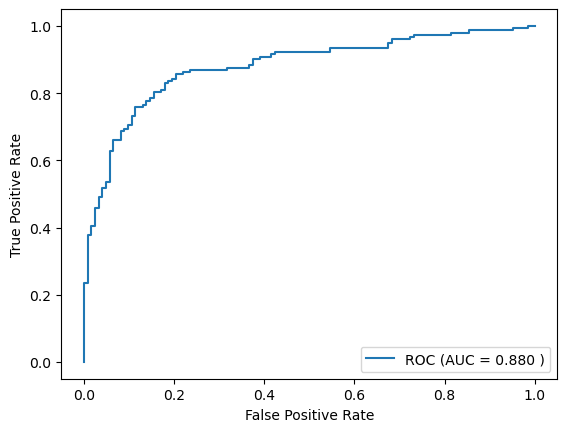

In [111]:
show_metrics(heart_data, list_feature, "linear", random_state)